# **Assignment 4:** Implementing LeNet-5 and Hyperparameter Optimization

## Part 1 - Classic LeNet-5 Implementation


### Introduction
In this notebook, the classic LeNet-5 architecture is implemented from scratch as described by LeCun et al. (1998). The goal is to reproduce the architecture without modern deep learning techniques (like Batch Norm, Dropout, or Adam) and achieve at least 98% accuracy on the MNIST test set.

**Requirements:**
* Input size: 32x32 (requires resizing MNIST)
* Activation: Tanh (Original) instead of ReLU
* Pooling: Average Pooling instead of Max Pooling
* Optimizer: SGD

### Imports and Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Reproducibility
torch.manual_seed(42)

Using device: cpu


### Data Loading (MNIST)

In [2]:
# LeNet-5 expects 32x32 inputs, but MNIST is 28x28. We must resize.
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # Standard MNIST mean/std
])

# Load Datasets (Complete dataset as per requirements)
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 37.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.04MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.63MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.38MB/s]

Training samples: 60000
Test samples: 10000


### LeNet-5 Architecture

In [3]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        # Layer C1: Convolutional Layer (1 input -> 6 outputs, 5x5 kernel)
        self.c1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        
        # Layer S2: Subsampling (Average Pooling, 2x2, stride 2)
        # Note: Original paper used Scaled Avg Pooling, but standard AvgPool is the accepted proxy in PyTorch
        self.s2 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # Layer C3: Convolutional Layer (6 inputs -> 16 outputs, 5x5 kernel)
        self.c3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        
        # Layer S4: Subsampling (Average Pooling, 2x2, stride 2)
        self.s4 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # Layer C5: Fully Connected (Convolutional in concept) (16*5*5 -> 120)
        self.c5 = nn.Linear(16 * 5 * 5, 120)
        
        # Layer F6: Fully Connected (120 -> 84)
        self.f6 = nn.Linear(120, 84)
        
        # Output Layer: (84 -> 10)
        self.output = nn.Linear(84, 10)
        
        # Activation Function: Tanh (Original LeNet used Sigmoid/Tanh, not ReLU)
        self.act = nn.Tanh()

    def forward(self, x):
        # C1 -> Tanh -> S2
        x = self.s2(self.act(self.c1(x)))
        
        # C3 -> Tanh -> S4
        x = self.s4(self.act(self.c3(x)))
        
        # Flatten
        x = x.view(-1, 16 * 5 * 5)
        
        # C5 -> Tanh
        x = self.act(self.c5(x))
        
        # F6 -> Tanh
        x = self.act(self.f6(x))
        
        # Output (No activation here, CrossEntropyLoss handles Softmax)
        x = self.output(x)
        return x

model = LeNet5().to(device)
print(model)

LeNet5(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (s2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (c5): Linear(in_features=400, out_features=120, bias=True)
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=10, bias=True)
  (act): Tanh()
)


### Training Loop

In [4]:
# Hyperparameters
EPOCHS = 20  # As requested (20-30 reasonable)
LR = 0.01    # Standard SGD learning rate
MOMENTUM = 0.9

# Loss and Optimizer (No Adam allowed)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)

# Metrics Storage
history = {
    'train_loss': [], 'train_acc': [],
    'test_loss': [], 'test_acc': []
}

print("Starting Training...")

for epoch in range(EPOCHS):
    # --- Training ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    
    # --- Evaluation ---
    model.eval()
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
    avg_test_loss = running_test_loss / len(test_loader)
    test_acc = 100 * correct_test / total_test
    
    # Store metrics
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(avg_test_loss)
    history['test_acc'].append(test_acc)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Test Loss: {avg_test_loss:.4f} | Test Acc: {test_acc:.2f}%")

print("Training Completed.")

Starting Training...
Epoch [1/20] Train Loss: 0.3774 | Train Acc: 89.43% | Test Loss: 0.1177 | Test Acc: 96.45%
Epoch [2/20] Train Loss: 0.0900 | Train Acc: 97.33% | Test Loss: 0.0593 | Test Acc: 98.18%
Epoch [3/20] Train Loss: 0.0601 | Train Acc: 98.20% | Test Loss: 0.0465 | Test Acc: 98.47%
Epoch [4/20] Train Loss: 0.0465 | Train Acc: 98.57% | Test Loss: 0.0504 | Test Acc: 98.29%
Epoch [5/20] Train Loss: 0.0386 | Train Acc: 98.84% | Test Loss: 0.0415 | Test Acc: 98.71%
Epoch [6/20] Train Loss: 0.0332 | Train Acc: 98.95% | Test Loss: 0.0365 | Test Acc: 98.83%
Epoch [7/20] Train Loss: 0.0292 | Train Acc: 99.08% | Test Loss: 0.0333 | Test Acc: 98.80%
Epoch [8/20] Train Loss: 0.0247 | Train Acc: 99.27% | Test Loss: 0.0373 | Test Acc: 98.81%
Epoch [9/20] Train Loss: 0.0218 | Train Acc: 99.35% | Test Loss: 0.0330 | Test Acc: 98.81%
Epoch [10/20] Train Loss: 0.0198 | Train Acc: 99.42% | Test Loss: 0.0317 | Test Acc: 99.05%
Epoch [11/20] Train Loss: 0.0174 | Train Acc: 99.50% | Test Loss: 0.

### Plotting Results

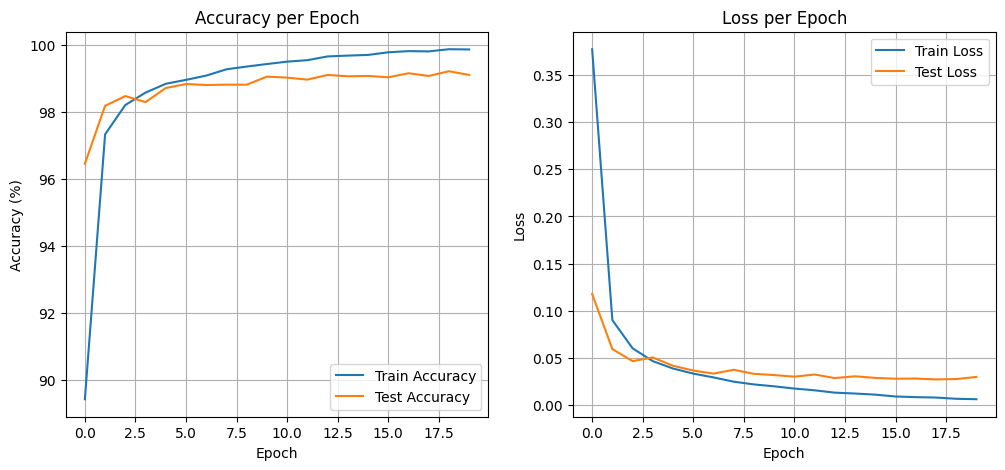

Final Test Accuracy: 99.10%


In [5]:
# Plot Training Curves
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['test_acc'], label='Test Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

print(f"Final Test Accuracy: {history['test_acc'][-1]:.2f}%")

### Save Model

In [6]:
# Save the model state dictionary for Part 2 comparison
torch.save(model.state_dict(), "lenet5_baseline.pth")
print("Baseline model saved as 'lenet5_baseline.pth'")

Baseline model saved as 'lenet5_baseline.pth'


## Part 2 - Modern and Optimized Implementation

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 1. Setup Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Define the Optimized LeNet-5 (Based on Trial 29 Parameters)
class OptimizedLeNet5(nn.Module):
    def __init__(self):
        super(OptimizedLeNet5, self).__init__()
        # Optimized Hyperparameters from Trial 29
        # c1_filters: 10, c3_filters: 28, f5: 90, f6: 90, act: tanh
        
        self.c1 = nn.Conv2d(1, 10, kernel_size=5) # 10 filters
        self.s2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.c3 = nn.Conv2d(10, 28, kernel_size=5) # 28 filters
        self.s4 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # Flatten size: 28 filters * 5 * 5 spatial dimension
        self.flatten_size = 28 * 5 * 5 
        
        self.f5 = nn.Linear(self.flatten_size, 90) # 90 units
        self.f6 = nn.Linear(90, 90)               # 90 units
        self.output = nn.Linear(90, 10)
        
        self.act = nn.Tanh() # Activation: Tanh

    def forward(self, x):
        x = self.s2(self.act(self.c1(x)))
        x = self.s4(self.act(self.c3(x)))
        x = x.view(-1, self.flatten_size)
        x = self.act(self.f5(x))
        x = self.act(self.f6(x))
        x = self.output(x)
        return x

# 3. Load COMPLETE Dataset (No Validation Split this time)
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Use the full training set for the final run
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# 4. Training Loop
model_opt = OptimizedLeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_opt.parameters(), lr=0.01, momentum=0.9)

opt_history = {'train_acc': [], 'test_acc': []}
EPOCHS = 20

print("Starting Final Training of Optimized Model...")
for epoch in range(EPOCHS):
    model_opt.train()
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_opt(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_acc = 100 * correct / total
    opt_history['train_acc'].append(train_acc)
    
    # Evaluate on Test Set
    model_opt.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_opt(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
    test_acc = 100 * correct_test / total_test
    opt_history['test_acc'].append(test_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

print(f"Final Optimized Test Accuracy: {opt_history['test_acc'][-1]:.2f}%")

Starting Final Training of Optimized Model...
Epoch 1/20 | Train Acc: 85.64% | Test Acc: 94.89%
Epoch 2/20 | Train Acc: 96.23% | Test Acc: 97.34%
Epoch 3/20 | Train Acc: 97.72% | Test Acc: 98.29%
Epoch 4/20 | Train Acc: 98.32% | Test Acc: 98.64%
Epoch 5/20 | Train Acc: 98.53% | Test Acc: 98.62%
Epoch 6/20 | Train Acc: 98.80% | Test Acc: 98.82%
Epoch 7/20 | Train Acc: 98.93% | Test Acc: 98.98%
Epoch 8/20 | Train Acc: 99.02% | Test Acc: 98.94%
Epoch 9/20 | Train Acc: 99.15% | Test Acc: 98.99%
Epoch 10/20 | Train Acc: 99.23% | Test Acc: 99.08%
Epoch 11/20 | Train Acc: 99.29% | Test Acc: 98.99%
Epoch 12/20 | Train Acc: 99.39% | Test Acc: 98.98%
Epoch 13/20 | Train Acc: 99.46% | Test Acc: 99.07%
Epoch 14/20 | Train Acc: 99.52% | Test Acc: 99.05%
Epoch 15/20 | Train Acc: 99.52% | Test Acc: 99.16%
Epoch 16/20 | Train Acc: 99.58% | Test Acc: 99.15%
Epoch 17/20 | Train Acc: 99.67% | Test Acc: 99.20%
Epoch 18/20 | Train Acc: 99.67% | Test Acc: 99.15%
Epoch 19/20 | Train Acc: 99.71% | Test Acc: 9

### Comparison Plots

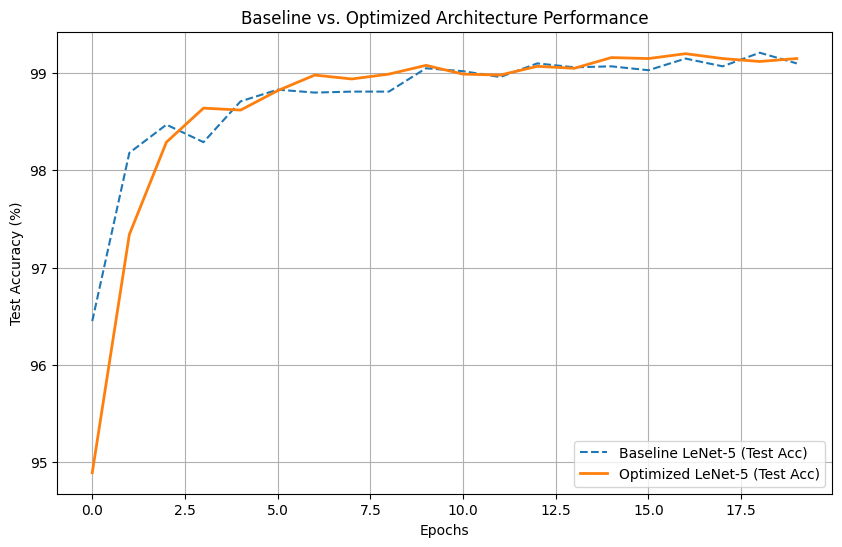

In [8]:
# Assuming you have 'history' from Part 1 and 'opt_history' from Part 2 above

plt.figure(figsize=(10, 6))
plt.plot(history['test_acc'], label='Baseline LeNet-5 (Test Acc)', linestyle='--')
plt.plot(opt_history['test_acc'], label='Optimized LeNet-5 (Test Acc)', linewidth=2)
plt.title('Baseline vs. Optimized Architecture Performance')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy (%)')
plt.legend()
plt.grid(True)
plt.savefig('comparison_plot.png')
plt.show()